# Bayesian Optimization for GAMMA PID

use GAMMA_TiDE_BO

In [7]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# from scipy.optimize import minimize, Bounds

# For TiDE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F

import os
import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward

from RobustMPC_pytorch import RMPC
from nn_functions import surrogate
from torchmin import minimize as pytorch_minimize
from scipy.optimize import minimize, Bounds

from moving_average import moving_average_1d
import copy

from GAMMA_obj import GAMMA_obj
from obj_fun import RMPC_obj_wo_constraint, RMPC_obj_wo_constraint_scipy
from GAMMA_MPC import GAMMA_MPC


# for BO
import pandas as pd
from botorch.utils.transforms import unnormalize, normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from torch.optim import Adam

import gpytorch
import scipy
from scipy.stats import qmc
from scipy.stats import linregress


cuda is available


## Design of experiment

## Run Initial designs

In [8]:
def generate_sobol_sequence(dimensions, n_points, lower_bounds, upper_bounds):
    # Create a Sobol sequence generator
    sobol = qmc.Sobol(d=dimensions)
    
    # Generate n_points points in the Sobol sequence
    sequence = sobol.random(n=n_points)
    
    # Scale the sequence to the specified bounds
    scaled_sequence = qmc.scale(sequence, lower_bounds, upper_bounds)
    
    return scaled_sequence


#### DOE requirements

In [9]:
dimensions = 3  # Number of dimensions
n_points = 30   # Number of points to generate
lower_bounds = [0, 0, 0]  # Lower bounds for each dimension
upper_bounds = [0.2, 0.02, 0.01]  # Upper bounds for each dimension

DOE = generate_sobol_sequence(dimensions, n_points, lower_bounds, upper_bounds)

In [10]:
DOE

array([[1.35052031e-01, 1.73556641e-02, 5.13821038e-03],
       [2.64914505e-02, 7.26215404e-03, 3.96368922e-03],
       [7.35004669e-02, 1.00472619e-02, 7.67869423e-03],
       [1.64946896e-01, 1.78666413e-04, 1.34319224e-03],
       [1.81407352e-01, 1.47195392e-02, 3.50572228e-03],
       [7.89272448e-02, 4.90092048e-03, 7.47294636e-03],
       [2.10783578e-02, 1.77213006e-02, 1.19717337e-03],
       [1.18602304e-01, 7.50198608e-03, 9.70037589e-03],
       [1.05662487e-01, 1.21109069e-02, 5.36833340e-04],
       [7.84327090e-03, 2.01864175e-03, 9.19183339e-03],
       [9.21569912e-02, 1.54470265e-02, 2.91578368e-03],
       [1.94346406e-01, 5.57967592e-03, 6.73176336e-03],
       [1.52982105e-01, 1.94759981e-02, 8.41933036e-03],
       [6.16341067e-02, 9.65617327e-03, 1.93256728e-03],
       [3.83555219e-02, 1.31223002e-02, 5.64731466e-03],
       [1.47013008e-01, 2.90177958e-03, 4.62456957e-03],
       [1.38714548e-01, 1.35607123e-02, 8.87023506e-03],
       [4.74383023e-02, 3.69143

#### Initialize main function

In [11]:
with open('TiDE_params_single_track_square_MV_lp_less_cov.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
P = 50
window = 50

TiDE = surrogate(nominal_params, nominal_TiDE)

INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 2500
window = 50
sim_interval = 5
init_runs = 50

def compute_r2(y_true, y_pred):
    # Compute the correlation coefficient
    correlation_matrix = np.corrcoef(y_true, y_pred)
    correlation_xy = correlation_matrix[0, 1]
    # Compute R^2
    r_squared = correlation_xy**2
    return r_squared

def run_gamma_with_PID_gain(Kp, Ki, Kd):

    GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
    init_avg = GAMMA_class.run_initial_steps()
    init_avg = torch.tensor(init_avg,dtype=torch.float32)

    df_one_print = pd.read_csv('single_track_ref.csv')

    loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
    loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
    loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
    dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
    dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
    scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)
    # laser on/off indicator
    laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)
    # laser power
    laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
    laser_power_past = laser_power_ref[:window]

    # fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
    fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

    # temporary ref
    # apply moving average for mp temp
    mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
    mp_temp_mv = moving_average_1d(mp_temp_raw,4)
    mp_temp = copy.deepcopy(mp_temp_raw)
    mp_temp[1:-2] = mp_temp_mv
    mp_temp = mp_temp

    mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

    MPC_GAMMA = GAMMA_MPC(GAMMA_class, TiDE, RMPC_obj_wo_constraint, mp_temp_ref, window, P, fix_covariates, init_avg, laser_power_past)
    #N_step = 6021 #6196
    #N_step = 6196

    N_step = 2000

    MPC_GAMMA.PID_Kp = Kp
    MPC_GAMMA.PID_Ki = Ki
    MPC_GAMMA.PID_Kd = Kd

    ref = MPC_GAMMA.ref[:N_step]
    
    for _ in tqdm(range(N_step)):
        MPC_GAMMA.PID_run_one_step()
         
    return compute_r2(ref, MPC_GAMMA.x_past_save[:N_step].squeeze())


In [12]:
saved_r2_value = np.zeros([n_points,1])

for i in range(n_points):
    saved_r2_value[i] = run_gamma_with_PID_gain(Kp=DOE[i,0], Ki=DOE[i,1], Kd=DOE[i,2])
    print(f"finish iteration {i}")




100%|██████████| 2000/2000 [14:37<00:00,  2.28it/s]


finish iteration 0


100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


finish iteration 1


100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


finish iteration 2


100%|██████████| 2000/2000 [14:42<00:00,  2.27it/s]


finish iteration 3


100%|██████████| 2000/2000 [14:46<00:00,  2.26it/s]


finish iteration 4


100%|██████████| 2000/2000 [14:41<00:00,  2.27it/s]


finish iteration 5


100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


finish iteration 6


100%|██████████| 2000/2000 [14:46<00:00,  2.26it/s]


finish iteration 7


100%|██████████| 2000/2000 [14:41<00:00,  2.27it/s]


finish iteration 8


100%|██████████| 2000/2000 [14:38<00:00,  2.28it/s]


finish iteration 9


100%|██████████| 2000/2000 [14:46<00:00,  2.26it/s]


finish iteration 10


100%|██████████| 2000/2000 [14:40<00:00,  2.27it/s]


finish iteration 11


100%|██████████| 2000/2000 [14:39<00:00,  2.28it/s]


finish iteration 12


100%|██████████| 2000/2000 [14:59<00:00,  2.22it/s]


finish iteration 13


100%|██████████| 2000/2000 [15:35<00:00,  2.14it/s]


finish iteration 14


100%|██████████| 2000/2000 [15:42<00:00,  2.12it/s]


finish iteration 15


100%|██████████| 2000/2000 [14:43<00:00,  2.26it/s]


finish iteration 16


100%|██████████| 2000/2000 [14:49<00:00,  2.25it/s]


finish iteration 17


100%|██████████| 2000/2000 [14:42<00:00,  2.27it/s]


finish iteration 18


100%|██████████| 2000/2000 [14:40<00:00,  2.27it/s]


finish iteration 19


100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


finish iteration 20


100%|██████████| 2000/2000 [14:40<00:00,  2.27it/s]


finish iteration 21


100%|██████████| 2000/2000 [14:35<00:00,  2.28it/s]


finish iteration 22


100%|██████████| 2000/2000 [14:44<00:00,  2.26it/s]


finish iteration 23


100%|██████████| 2000/2000 [14:38<00:00,  2.28it/s]


finish iteration 24


100%|██████████| 2000/2000 [14:39<00:00,  2.27it/s]


finish iteration 25


100%|██████████| 2000/2000 [09:07<00:00,  3.66it/s]


finish iteration 26


100%|██████████| 2000/2000 [08:11<00:00,  4.07it/s]


finish iteration 27


100%|██████████| 2000/2000 [08:15<00:00,  4.04it/s]


finish iteration 28


100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s]

finish iteration 29


In [13]:
import pickle

with open('BO_output.pkl', 'wb') as f:
    pickle.dump(saved_r2_value, f)
    
with open('BO_input.pkl', 'wb') as f:
    pickle.dump(DOE, f)

## BO

In [14]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_x = torch.tensor(DOE).to(device)
train_y = torch.tensor(saved_r2_value).to(device)


for i in range(30):
    train_ys = standardize(train_y)

    gp = SingleTaskGP(train_x, train_ys)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    EI = ExpectedImprovement(gp, best_f=train_ys.max())

    # Optimize the acquisition function
    bounds = torch.tensor([[0.0, 0.0, 0.0], [0.2, 0.02, 0.02]], device=device)
    candidate, acq_value = optimize_acqf(
        EI,
        bounds=bounds,
        q=1,  # number of candidates to return
        num_restarts=5,
        raw_samples=20,  # used for initialization heuristic
    )
    
    new_x = candidate
    new_y = run_gamma_with_PID_gain(Kp=candidate[0,0].item(), Ki=candidate[0,1].item(), Kd=candidate[0,2].item())
    print(f"iter = {i}, candidate = {new_x}, r2 = {new_y}")
    
    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, torch.tensor(new_y).reshape(-1,1).to(device)])

100%|██████████| 2000/2000 [08:13<00:00,  4.05it/s]


iter = 0, candidate = tensor([[0.0000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9553803121880325


100%|██████████| 2000/2000 [08:15<00:00,  4.04it/s]


iter = 1, candidate = tensor([[0.0000, 0.0000, 0.0064]], device='cuda:0'), r2 = 0.9618421559988919


100%|██████████| 2000/2000 [07:16<00:00,  4.58it/s]


iter = 2, candidate = tensor([[0.0000, 0.0200, 0.0000]], device='cuda:0'), r2 = 0.08848743984556517


100%|██████████| 2000/2000 [08:09<00:00,  4.09it/s]


iter = 3, candidate = tensor([[0.2000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9061904941852321


100%|██████████| 2000/2000 [08:17<00:00,  4.02it/s]


iter = 4, candidate = tensor([[0.2000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9102162587185658


100%|██████████| 2000/2000 [08:38<00:00,  3.86it/s]


iter = 5, candidate = tensor([[0.2000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9102162600018858


100%|██████████| 2000/2000 [08:44<00:00,  3.81it/s]


iter = 6, candidate = tensor([[0.2000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9102162626527002


100%|██████████| 2000/2000 [08:51<00:00,  3.76it/s]


iter = 7, candidate = tensor([[0.2000, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9102162592339292


100%|██████████| 2000/2000 [08:48<00:00,  3.78it/s]


iter = 8, candidate = tensor([[0.1240, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9400582129440244


100%|██████████| 2000/2000 [08:50<00:00,  3.77it/s]


iter = 9, candidate = tensor([[0.1253, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9398659403964398


100%|██████████| 2000/2000 [08:19<00:00,  4.00it/s]


iter = 10, candidate = tensor([[0.1262, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9394377357571655


100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s]


iter = 11, candidate = tensor([[0.1268, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.938261195707629


100%|██████████| 2000/2000 [08:18<00:00,  4.01it/s]


iter = 12, candidate = tensor([[0.1272, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9376243580504805


100%|██████████| 2000/2000 [08:17<00:00,  4.02it/s]


iter = 13, candidate = tensor([[0.2000, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9364623204449821


100%|██████████| 2000/2000 [09:15<00:00,  3.60it/s]


iter = 14, candidate = tensor([[0.1307, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.951186519806934


100%|██████████| 2000/2000 [10:46<00:00,  3.09it/s]


iter = 15, candidate = tensor([[0.1226, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.939256910971155


100%|██████████| 2000/2000 [08:23<00:00,  3.97it/s]


iter = 16, candidate = tensor([[0.1228, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9387493500130438


100%|██████████| 2000/2000 [08:18<00:00,  4.01it/s]


iter = 17, candidate = tensor([[0.2000, 0.0200, 0.0000]], device='cuda:0'), r2 = 0.9348154147265444


100%|██████████| 2000/2000 [13:43<00:00,  2.43it/s]


iter = 18, candidate = tensor([[0.1276, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9527494483414871


100%|██████████| 2000/2000 [15:43<00:00,  2.12it/s]


iter = 19, candidate = tensor([[0.2000, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9361853113440703


100%|██████████| 2000/2000 [13:42<00:00,  2.43it/s]


iter = 20, candidate = tensor([[0.1237, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.952965633075647


100%|██████████| 2000/2000 [08:19<00:00,  4.01it/s]


iter = 21, candidate = tensor([[0.1228, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9533723102168923


100%|██████████| 2000/2000 [08:23<00:00,  3.97it/s]


iter = 22, candidate = tensor([[0.1174, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9416456160723109


100%|██████████| 2000/2000 [08:17<00:00,  4.02it/s]


iter = 23, candidate = tensor([[0.1174, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9403100875718393


100%|██████████| 2000/2000 [08:20<00:00,  4.00it/s]


iter = 24, candidate = tensor([[0.1174, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9392854370526281


100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s]


iter = 25, candidate = tensor([[0.1229, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9532566975099014


100%|██████████| 2000/2000 [08:20<00:00,  4.00it/s]


iter = 26, candidate = tensor([[0.1220, 0.0000, 0.0000]], device='cuda:0'), r2 = 0.9523569891017046


100%|██████████| 2000/2000 [08:13<00:00,  4.05it/s]


iter = 27, candidate = tensor([[0.1156, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.941614415791799


100%|██████████| 2000/2000 [08:18<00:00,  4.02it/s]


iter = 28, candidate = tensor([[0.2000, 0.0200, 0.0000]], device='cuda:0'), r2 = 0.9348154147441429


100%|██████████| 2000/2000 [08:13<00:00,  4.05it/s]

iter = 29, candidate = tensor([[0.1154, 0.0000, 0.0200]], device='cuda:0'), r2 = 0.9417090623647778


22

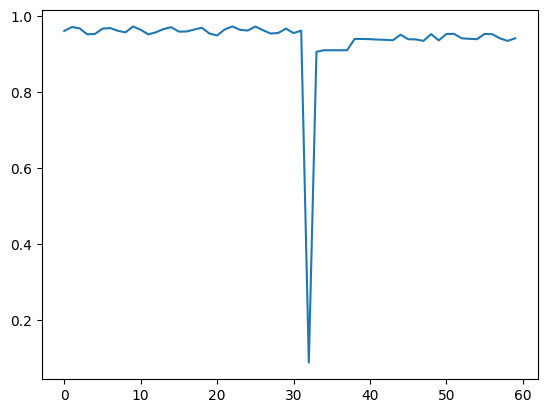

In [15]:
plt.plot(train_y.cpu())
np.argmax(train_y.cpu().numpy())